<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE40455-2020](https://jckantor.github.io/CBE40455-2020);
content is available [on Github](https://github.com/jckantor/CBE40455-2020.git).*


<!--NAVIGATION-->
< [3.4 Modeling Events](https://jckantor.github.io/CBE40455-2020/03.04-Modeling-Events.html) | [Contents](toc.html) | [3.6 Simulating Queuing Systems](https://jckantor.github.io/CBE40455-2020/03.06-Queuing-Systems-and-Poisson-Processes.html) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.05-Assignment.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.05-Assignment.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.5 Assignment

(to be submitted Thursday, Sept. 3rd).

## 3.5.1 Problem Statement 

The facility has expanded to an average of 100 hours of machine cleaning time are required during the 16 hour overnight shift. The company would like to settle on a single cleaning model rather than servicing five different models. 

a. Modify the above model to determine the the model (A, B, C, D, or E) and number of devices required to meet the service requirement.

b. Modify the above model to include a second process that writes the number of charging stations in use at every minute to a second data log. Prepare a plot and histogram of charging station usage.

## 3.5.2 Solution

### 3.5.2.1 Preliminaries

#### 3.5.2.1.1 Installation, Import, and Setup

In [21]:
# necessary installations
!pip install simpy

# import section
import simpy 
import pandas as pd
import numpy as np

#### 3.5.2.1.2 Data section

In [22]:
# data section

roomba_data = [
    ["A", 1.0, 2.5],
    ["B", 0.5, 1.5],
    ["C", 0.8, 2.0],
    ["D", 1.4, 3.5],
    ["E", 0.5, 1.2],
]

roomba_df = pd.DataFrame(roomba_data, columns=["id", "charge_time", "clean_time"])
display(roomba_df)

,id,charge_time,clean_time
0,A,1.0,2.5
1,B,0.5,1.5
2,C,0.8,2.0
3,D,1.4,3.5
4,E,0.5,1.2


#### 3.5.2.1.3 Key performance indictors

In [23]:
def kpi(df):
    df["time"] = df["end"] - df["begin"]
    return pd.pivot_table(df, index=["event"], values="time", aggfunc={"time":np.sum} )

#### 3.5.2.1.4 Gantt charts

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def gantt(df, lw=10):
    
    # create sorted lists of the unique ids and events appearing in the data log
    ids = sorted(list(set(df["id"])))
    events = sorted(list(set(df["event"])))
    
    # create list of unique colors for each event
    colors = [f"C{i}" for i in range(len(events))]
    
    # create plot window
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    
    # for each event and id, find entries in the data log and plot the begin and end points
    for i, event in enumerate(events):
        for j, id in enumerate(ids):  
            for k in df[(df["id"]==id) & (df["event"]==event)].index:
                ax.plot([df["begin"][k], df["end"][k]], [j,j], 
                        colors[i], solid_capstyle="butt", lw=lw)
                
    # create legend
    lines = [Line2D([0], [0], lw=lw, color=colors[i]) for i in range(len(events))]
    ax.legend(lines, events, bbox_to_anchor=(0.0, 1.1), loc="lower left")
    
    # annotate the axes
    ax.set_yticks(range(len(ids)))
    ax.set_yticklabels(ids)
    ax.grid(True)
    ax.set_xlabel("Time")
    ax.set_title("Gannt Chart")
    for sp in ['top', 'bottom', 'right', 'left']:
        ax.spines[sp].set_visible(False)

### 3.5.2.2 Which model of Roomba is preferred?

#### 3.5.2.2.1 Model

In [28]:
import random

five_min = 5.0/60.0
ten_min = 10.0/60.0
twenty_min = 20.0/60.0
thirty_min = 30.0/60.0

def roomba_model(id, charge_time, clean_time, reserve=0.1):
    soc = 1.0   # state of charge
    sow = 0.0   # state of waste
    while True:
        if soc > reserve and sow < 1.0:
            tic = env.now
            yield simpy.AnyOf(env, [env.timeout((soc - reserve) * clean_time), 
                                           env.timeout((1.0 - sow)*random.uniform(ten_min, thirty_min))])
            toc = env.now
            soc = max(0.0, soc - (toc - tic)/clean_time)
            sow = min(1.0, sow + (toc - tic)/twenty_min)
            data_log.append([id, "cleaning", tic, toc])
        if sow >= 1.0 - 0.001:
            with waste_stations.request() as request:
                yield request
                tic = env.now
                yield env.timeout(five_min)
                toc = env.now
                sow = 0.0
                data_log.append([id, "waste disposal", tic, toc])
        if soc <= reserve+ 0.001:
            with chargers.request() as request:
                yield request
                tic = env.now
                yield env.timeout((1 - soc)*charge_time)
                toc = env.now
                soc = min(1.0, soc + (toc - tic)/charge_time)
                data_log.append([id, "charging", tic, toc])
            

#### 3.5.2.2.2 Simulation

Our strategy will be to determine, first, which model can provide 100 hours of cleaning with the fewest units. For this determination we will use an equal number of charging and waste stations. 

In [43]:
N = 10

for r in roomba_df.index:
    
    data_log = []

    env = simpy.Environment()
    chargers = simpy.Resource(env, capacity=N)
    waste_stations = simpy.Resource(env, capacity=N)
    for k in range(N):
        env.process(roomba_model(roomba_df["id"][r] + str(k), roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
    env.run(until=16)

    df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
    print("Model ", roomba_df["id"][r])
    display(kpi(df))
    #gantt(df)

Model  A


,time
event,
charging,36.000000
cleaning,99.893153
waste disposal,21.833333


Model  B


,time
event,
charging,31.500000
cleaning,104.283599
waste disposal,22.916667


Model  C


,time
event,
charging,35.999747
cleaning,100.389862
waste disposal,22.083333


Model  D


,time
event,
charging,37.800000
cleaning,99.179123
waste disposal,21.250000


Model  E


,time
event,
charging,40.049716
cleaning,97.295496
waste disposal,21.666667


Both models B and C can meet the 100 specification with 10 units, but model B has a clear advantage. So will continue the analysis with model B. Next determine the minimum number of charging and waste stations while still meeting the 100 hour requirement.

### 3.5.2.3 Charging station analysis

#### 3.5.2.3.1 Modell

In [42]:
import random

five_min = 5.0/60.0
ten_min = 10.0/60.0
twenty_min = 20.0/60.0
thirty_min = 30.0/60.0

def roomba_model(id, charge_time, clean_time, reserve=0.1):
    soc = 1.0   # state of charge
    sow = 0.0   # state of waste
    while True:
        if soc > reserve and sow < 1.0:
            tic = env.now
            yield simpy.AnyOf(env, [env.timeout((soc - reserve) * clean_time), 
                                           env.timeout((1.0 - sow)*random.uniform(ten_min, thirty_min))])
            toc = env.now
            soc = max(0.0, soc - (toc - tic)/clean_time)
            sow = min(1.0, sow + (toc - tic)/twenty_min)
            data_log.append([id, "cleaning", tic, toc])
        if sow >= 1.0 - 0.001:
            with waste_stations.request() as request:
                yield request
                tic = env.now
                yield env.timeout(five_min)
                toc = env.now
                sow = 0.0
                data_log.append([id, "waste disposal", tic, toc])
        if soc <= reserve+ 0.001:
            with chargers.request() as request:
                yield request
                tic = env.now
                charger_log.append([chargers.count, tic])
                yield env.timeout((1 - soc)*charge_time)
                toc = env.now
                soc = min(1.0, soc + (toc - tic)/charge_time)
                data_log.append([id, "charging", tic, toc])
            charger_log.append([chargers.count, toc])
            

,time
event,
charging,18.180000
cleaning,50.115622
waste disposal,10.916667


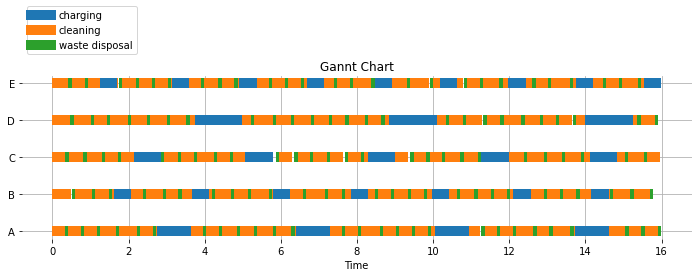

In [26]:
data_log = []
charger_log = [[0, 0]]

env = simpy.Environment()
chargers = simpy.Resource(env, capacity=5)
waste_stations = simpy.Resource(env, capacity=2)
for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(kpi(df))
gantt(df)

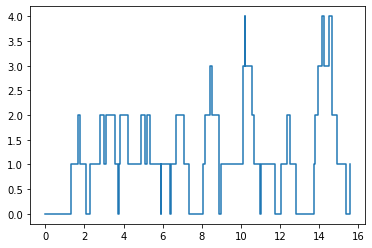

In [54]:
charger_df = pd.DataFrame(charger_log, columns=["count", "time"])
plt.step(charger_df["time"], charger_df["count"], where='post')

(array([11.,  0., 22.,  0.,  0., 14.,  0.,  6.,  0.,  3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

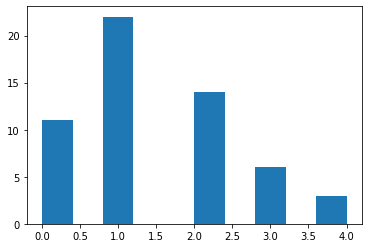

In [55]:
plt.hist(charger_df["count"])

<!--NAVIGATION-->
< [3.4 Modeling Events](https://jckantor.github.io/CBE40455-2020/03.04-Modeling-Events.html) | [Contents](toc.html) | [3.6 Simulating Queuing Systems](https://jckantor.github.io/CBE40455-2020/03.06-Queuing-Systems-and-Poisson-Processes.html) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.05-Assignment.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.05-Assignment.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>